# Training FairMOT

In [1]:
%cd /kaggle
! git clone -b pytorch_1.7 https://github.com/ifzhang/DCNv2.git
%cd /kaggle/DCNv2
! ./make.sh &> /dev/null

/kaggle
Cloning into 'DCNv2'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 263 (delta 9), reused 12 (delta 6), pack-reused 240
Receiving objects: 100% (263/263), 1.44 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/kaggle/DCNv2


In [2]:
%cd /kaggle
! git clone https://github.com/qAp/FairMOT.git
%cd /kaggle/FairMOT
! git checkout nfl_kaggle
! pip install -r requirements.txt &> /dev/null

/kaggle
Cloning into 'FairMOT'...
remote: Enumerating objects: 736, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 736 (delta 27), reused 28 (delta 12), pack-reused 681
Receiving objects: 100% (736/736), 63.35 MiB | 32.88 MiB/s, done.
Resolving deltas: 100% (387/387), done.
/kaggle/FairMOT
Branch 'nfl_kaggle' set up to track remote branch 'nfl_kaggle' from 'origin'.
Switched to a new branch 'nfl_kaggle'


In [3]:
! pip uninstall -y datasets

Found existing installation: datasets 1.12.1
Uninstalling datasets-1.12.1:
  Successfully uninstalled datasets-1.12.1


In [4]:
import os, sys
import json
import argparse
import os.path as osp
import subprocess
import numpy as np
import pandas as pd
import torch
from IPython.display import display, Video

sys.path.append('/kaggle/DCNv2')
sys.path.append('/kaggle/FairMOT')
sys.path.append('/kaggle/FairMOT/src')
sys.path.append('/kaggle/FairMOT/src/lib')
from datasets.dataset.jde import LoadVideo

In [5]:
! ls -lrt /kaggle/input/nfldata-fairmot/exp/mot/nfl_ft_mix_dla34/

total 701380
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-23-17-30
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-22-03-07
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-22-11-23
-rw-r--r-- 1 nobody nogroup      1950 Oct 28 16:36 opt.txt
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-16-11-47
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-21-17-53
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-28-08-01
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-11-07-40
drwxr-xr-x 2 nobody nogroup         0 Oct 28 16:36 logs_2021-10-27-07-29
-rw-r--r-- 1 nobody nogroup 242800233 Oct 28 16:36 model_10.pth
-rw-r--r-- 1 nobody nogroup 242800233 Oct 28 16:36 model_5.pth
-rw-r--r-- 1 nobody nogroup 242800233 Oct 28 16:36 model_last.pth


# Preparing NFL dataset

In [6]:
pth_trainfile = '/kaggle/FairMOT/src/data/nfl.train'
pth_cfgjson =   '/kaggle/FairMOT/src/lib/cfg/nfl.json'

In [7]:
dir_images_train = '/kaggle/input/nlf-gen-train-set-fairmot/NFL/images/train'

pths = []
for video in sorted(os.listdir(dir_images_train)):
    dir_jpg = os.path.join(dir_images_train, video, 'img1')
    for jpg in sorted(os.listdir(dir_jpg)):
        pth_jpg = os.path.join(dir_jpg, jpg)
        pths.append(pth_jpg)
        
pths = [os.path.join('NFL', pth.split('NFL/')[-1]) for pth in pths]
        
with open(pth_trainfile, mode='w') as f:
    f.write('\n'.join(pths))

In [8]:
! head {pth_trainfile}
! wc -l {pth_trainfile}

NFL/images/train/57583_000082_Endzone/img1/000001.jpg
NFL/images/train/57583_000082_Endzone/img1/000002.jpg
NFL/images/train/57583_000082_Endzone/img1/000003.jpg
NFL/images/train/57583_000082_Endzone/img1/000004.jpg
NFL/images/train/57583_000082_Endzone/img1/000005.jpg
NFL/images/train/57583_000082_Endzone/img1/000006.jpg
NFL/images/train/57583_000082_Endzone/img1/000007.jpg
NFL/images/train/57583_000082_Endzone/img1/000008.jpg
NFL/images/train/57583_000082_Endzone/img1/000009.jpg
NFL/images/train/57583_000082_Endzone/img1/000010.jpg
52140 /kaggle/FairMOT/src/data/nfl.train


In [9]:
# # For debugging, train on a subset of the images ~ 1%
# with open(pth_trainfile, mode='r') as f:
#     lines = f.readlines()[:500]
    
# with open(pth_trainfile, mode='w') as f:
#     f.writelines(lines)

# ! wc -l {pth_trainfile}

In [10]:
dict_cfg = {
    "root": "/kaggle/input/nlf-gen-train-set-fairmot", 
    "train": {"nfl": pth_trainfile},
    "test_emb": {"nfl": pth_trainfile},
    "test": {"nfl": pth_trainfile}
}

with open(pth_cfgjson, mode='w') as f:
    f.write(json.dumps(dict_cfg))

# Visualize some prepared samples

In [11]:
import cv2
import matplotlib.pyplot as plt

In [12]:
dir_labels_train = '/kaggle/input/nlf-gen-train-set-fairmot/NFL/labels_with_ids/train'

In [13]:
video = '57583_000082_Endzone'

In [14]:
# ! ls {dir_images_train}/{video}/img1

In [15]:
# ! ls {dir_labels_train}/{video}/img1

In [16]:
# ! cat /{dir_labels_train}/{video}/img1/000005.txt
# print()
# ! cat {dir_labels_train}/{video}/img1/000075.txt

In [17]:
# # Looks like frames are sorted by [seq, frame number]

# ! ls {dir_images_train}
# print()
# ! head {pth_trainfile}
# print()
# ! tail {pth_trainfile}

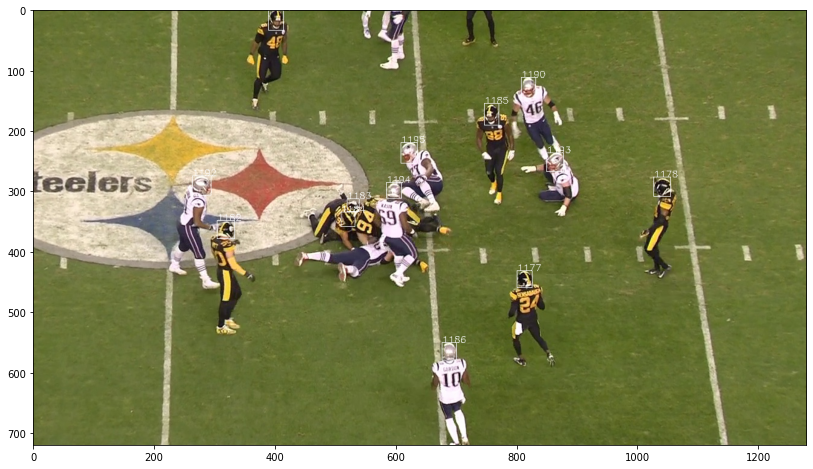

In [18]:
seq, imgid = '57788_000781_Sideline', 250

img = cv2.imread(f'/kaggle/input/nlf-gen-train-set-fairmot/NFL/images/train/{seq}/img1/{imgid:06d}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annot = pd.read_csv(f'/kaggle/input/nlf-gen-train-set-fairmot/NFL/labels_with_ids/train/{seq}/img1/{imgid:06d}.txt', 
                    header=None, sep=' ', usecols=range(1,6))
annot_ltrb = pd.concat(
    [
        annot.loc[:, 1],
        annot.loc[:, 2] - 0.5 * annot.loc[:, 4],
        annot.loc[:, 3] - 0.5 * annot.loc[:, 5],
        annot.loc[:, 2] + 0.5 * annot.loc[:, 4],
        annot.loc[:, 3] + 0.5 * annot.loc[:, 5]
    ], 
    axis=1, 
    keys=['class_id', 'left', 'top', 'right', 'bot'])

annot_ltrb.loc[:, ['left', 'right']] *= img.shape[1]
annot_ltrb.loc[:, ['top', 'bot']] *= img.shape[0]

for _, r in annot_ltrb.iterrows():
    r = r.astype(int)
    cv2.rectangle(img, 
                  pt1=(r['left'], r['top']), pt2=(r['right'], r['bot']), 
                  color=(255, 255, 255), thickness=1)
    cv2.putText(img,
                text=str(r['class_id']),
                org=(r['left'], r['top']),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, 
                color=(255, 255, 255),  
                thickness=1)

fig, ax = plt.subplots(figsize=(20, 8),)
ax.imshow(img);

In [19]:
# Looks like the seqs do not share any class ids.  
# Each class id is unique for the whole MOT15 collection.

# seqs = os.listdir('/kaggle/input/nlf-gen-train-set-fairmot/NFL/images/train')

# for seq in seqs:
#     class_ids = []
#     for fn in os.listdir(f'/kaggle/input/nlf-gen-train-set-fairmot/NFL/labels_with_ids/train/{seq}/img1'):
#         annot = pd.read_csv(os.path.join(f'/kaggle/input/nlf-gen-train-set-fairmot/NFL/labels_with_ids/train/{seq}/img1', fn), 
#                             sep=' ', header=None, usecols=range(1, 6))
#         class_ids.extend(list(annot.iloc[:, 0].values))
        
#     print(f'{seq}:')
#     print(f'class_ids:', np.array(set(class_ids)))
#     print()

# Training

In [20]:
from opts import opts
import src.train

Using tensorboardX


In [21]:
! cp -r /kaggle/input/nfldata-fairmot/exp /kaggle/working/.

In [22]:
args = ['mot',
        '--root_dir', '/kaggle/working',
        '--exp_id', 'nfl_ft_mix_dla34', 
#         '--load_model', '/kaggle/input/nfl04-fairmot-train/exp/mot/nfl_ft_mix_dla34/model_last.pth',
        '--resume',
        '--num_epochs', '16',
        '--lr_step', '15', 
        '--data_cfg', pth_cfgjson, 
        '--gpus', '0']

opt = opts().init(args)

Fix size testing.
training chunk_sizes: [12]
The output will be saved to  /kaggle/working/exp/mot/nfl_ft_mix_dla34
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}


In [23]:
src.train.main(opt)

Setting up data...
dataset summary
OrderedDict([('nfl', 2580.0)])
total # identities: 2581
start index
OrderedDict([('nfl', 0)])
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}
Namespace(K=500, arch='dla_34', batch_size=12, cat_spec_wh=False, chunk_sizes=[12], conf_thres=0.4, data_cfg='/kaggle/FairMOT/src/lib/cfg/nfl.json', data_dir='/home/zyf/dataset', dataset='jde', debug_dir='/kaggle/working/exp/mot/nfl_ft_mix_dla34/debug', dense_wh=False, det_thres=0.3, down_ratio=4, exp_dir='/kaggle/working/exp/mot', exp_id='nfl_ft_mix_dla34', fix_res=True, gpus=[0], gpus_str='0', head_conv=256, heads={'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, hide_data_time=False, hm_weight=1, id_loss='ce', id_weight=1, img_size=(1088, 608), input_h=608, input_res=1088, input_video='../videos/MOT16-03.mp4', input_w=1088, keep_res=False, load_model='/kaggle/working/exp/mot/nfl_ft_mix_dla34/model_last.pth', lr=0.0001, lr_step=[15], ltrb=True, master_batch_size=12, mean=None, metric='loss', min_box_area=100, mse_loss=Fa

Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/hub/checkpoints/dla34-ba72cf86.pth


  0%|          | 0.00/60.3M [00:00<?, ?B/s]

Starting training...
loaded /kaggle/working/exp/mot/nfl_ft_mix_dla34/model_last.pth, epoch 14


Resumed optimizer with start lr 0.0001
ZZZZZZ start_epoch =  14


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
mot/nfl_ft_mix_dla34 |################################| train: [15][4344/4345]|Tot: 3:43:24 |ETA: 0:00:04 |loss 1.5637 |hm_loss 0.2529 |wh_loss 0.1531 |off_loss 0.1116 |id_loss 1.4976 |Data 0.002s(0.004s) |Net 3.085s


Drop LR to 1e-05


mot/nfl_ft_mix_dla34 |################################| train: [16][4344/4345]|Tot: 3:43:18 |ETA: 0:00:04 |loss 0.0241 |hm_loss 0.2523 |wh_loss 0.1499 |off_loss 0.1103 |id_loss 0.3311 |Data 0.002s(0.004s) |Net 3.084s


In [24]:
# %cd /kaggle/working/exp/mot/
# ! zip -qr nfl_ft_mix_dla34.zip nfl_ft_mix_dla34/
# ! mv nfl_ft_mix_dla34.zip /kaggle/working/.